# Random Forest - Environmental sensor data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn import metrics
import seaborn as sns

## Preprocessing

In [2]:
data = pd.read_csv('iot_telemetry_data.csv')
print(data.isnull().sum())
devices = data.device.unique()
data = data.replace(devices, ['device 1', 'device 2', 'device 3'])
data['time'] = pd.to_datetime(data['ts'], unit='s')
data.drop('ts', inplace=True, axis=1)
data['light'] = data['light'].astype('int')
data['motion'] = data['motion'].astype('int')
print(data.corr())

ts          0
device      0
co          0
humidity    0
light       0
lpg         0
motion      0
smoke       0
temp        0
dtype: int64
                co  humidity     light       lpg    motion     smoke      temp
co        1.000000 -0.656750 -0.230197  0.997331 -0.000706  0.998192  0.110905
humidity -0.656750  1.000000  0.079703 -0.672113 -0.009826 -0.669863 -0.410427
light    -0.230197  0.079703  1.000000 -0.208926  0.033594 -0.212969  0.747485
lpg       0.997331 -0.672113 -0.208926  1.000000  0.000232  0.999916  0.136396
motion   -0.000706 -0.009826  0.033594  0.000232  1.000000  0.000062  0.037649
smoke     0.998192 -0.669863 -0.212969  0.999916  0.000062  1.000000  0.131891
temp      0.110905 -0.410427  0.747485  0.136396  0.037649  0.131891  1.000000


In [3]:
dev_1 = data[data.device == 'device 1']
dev_2 = data[data.device == 'device 2']
dev_3 = data[data.device == 'device 3']

## Functions

In [4]:
def FindLocalMin(numbers):
    minima = []
    length = len(numbers)
    for n in range(1, length - 1):
        if numbers[n] <= numbers[n - 1] and numbers[n] <= numbers[n + 1]:
            minima.append(numbers[n])
        if numbers[length - 1] <= numbers[length - 2]:
            minima.append(numbers[length - 1])
    return min(minima)

def data_clean(x, y, x_label, y_label, graphs):
    MSE = []
    rn = range(1000, 3100, 100)
    for s in rn:
        EMA = y.ewm(span=s, adjust=False).mean()
        weight = abs(1 / (.1 + y - EMA))
        # 0.1 is a small constant offset used to avoid division by zero
        mse = round(sm.mean_squared_error(y, EMA, sample_weight=weight), 2)
        MSE.append(mse)

    loc_min = FindLocalMin(MSE)
    idx_first_loc_min = MSE.index(loc_min)
    best_ema = y.ewm(span=rn[idx_first_loc_min], adjust=False).mean()

    if graphs == True:
        plt.figure(figsize=(25, 10))
        plt.subplot(1, 2, 1)
        plt.plot(x, y, color='lime', label='Data')
        plt.plot(x, best_ema, color='blue', linewidth=2, label='EMA')
        plt.xlabel(x_label, fontsize=18)
        plt.ylabel(y_label, fontsize=18)
        plt.legend(loc='upper right', prop={'size': 20})
        plt.tight_layout()

        plt.subplot(1, 2, 2)
        plt.plot(rn, MSE, label='MSE')
        plt.plot(rn[idx_first_loc_min], loc_min, marker='o', color='red', label='ideal n of data')
        plt.xlabel('number of data', fontsize=18)
        plt.ylabel('MSE', fontsize=18)
        plt.legend(loc='upper left', prop={'size': 20})

    plt.subplots_adjust(wspace=.1)
    plt.show()

    return best_ema

def conf_mat(test, pred):
    print('Accuracy=', metrics.accuracy_score(test, pred))
    c_m = metrics.confusion_matrix(test, pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(c_m/np.sum(c_m), annot=True, cmap='Blues_r', fmt='.2%',
                xticklabels=['absence', 'presence'],
                yticklabels=['absence', 'presence'])
    plt.xlabel('Predicted labels', fontsize=18)
    plt.ylabel('True labels', fontsize=18)
    plt.show()

The data_clean function can be divided into three steps:

- calculates EMA (exponential moving average) considering different amounts of data; it has the characteristic of taking into account more the recent values than previous ones. Furthermore, the original data contains outliers that differ significantly from the others, so a weight is considered in such a way that the farther the value is from the moving average, the less it is considered (0.1 is a small constant offset used to avoid division by zero);

- finds the ideal amount of EMA data via the MSE method;

- constructs two adjacent graphs representing the original data superimposed on EMA (left) and the MSE values for the different amounts of data and the value in red for the ideal one (right).


In [5]:
print(dev_1.corr())

                co  humidity     light       lpg    motion     smoke      temp
co        1.000000 -0.077022 -0.095929  0.999845 -0.003513  0.999895 -0.035695
humidity -0.077022  1.000000 -0.042066 -0.079296 -0.007169 -0.078891 -0.372977
light    -0.095929 -0.042066  1.000000 -0.096124  0.007202 -0.096093  0.008124
lpg       0.999845 -0.079296 -0.096124  1.000000 -0.003606  0.999995 -0.033369
motion   -0.003513 -0.007169  0.007202 -0.003606  1.000000 -0.003590 -0.000086
smoke     0.999895 -0.078891 -0.096093  0.999995 -0.003590  1.000000 -0.033786
temp     -0.035695 -0.372977  0.008124 -0.033369 -0.000086 -0.033786  1.000000


I apply the data_clean function on the 'humidity', 'smoke' and 'temperature' parameters no taking into account the 'co' and 'gpl' parameters as, together with the 'smoke' parameter, they have a covariance value close to 1 as proof which are highly correlated.

/Users/cris/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


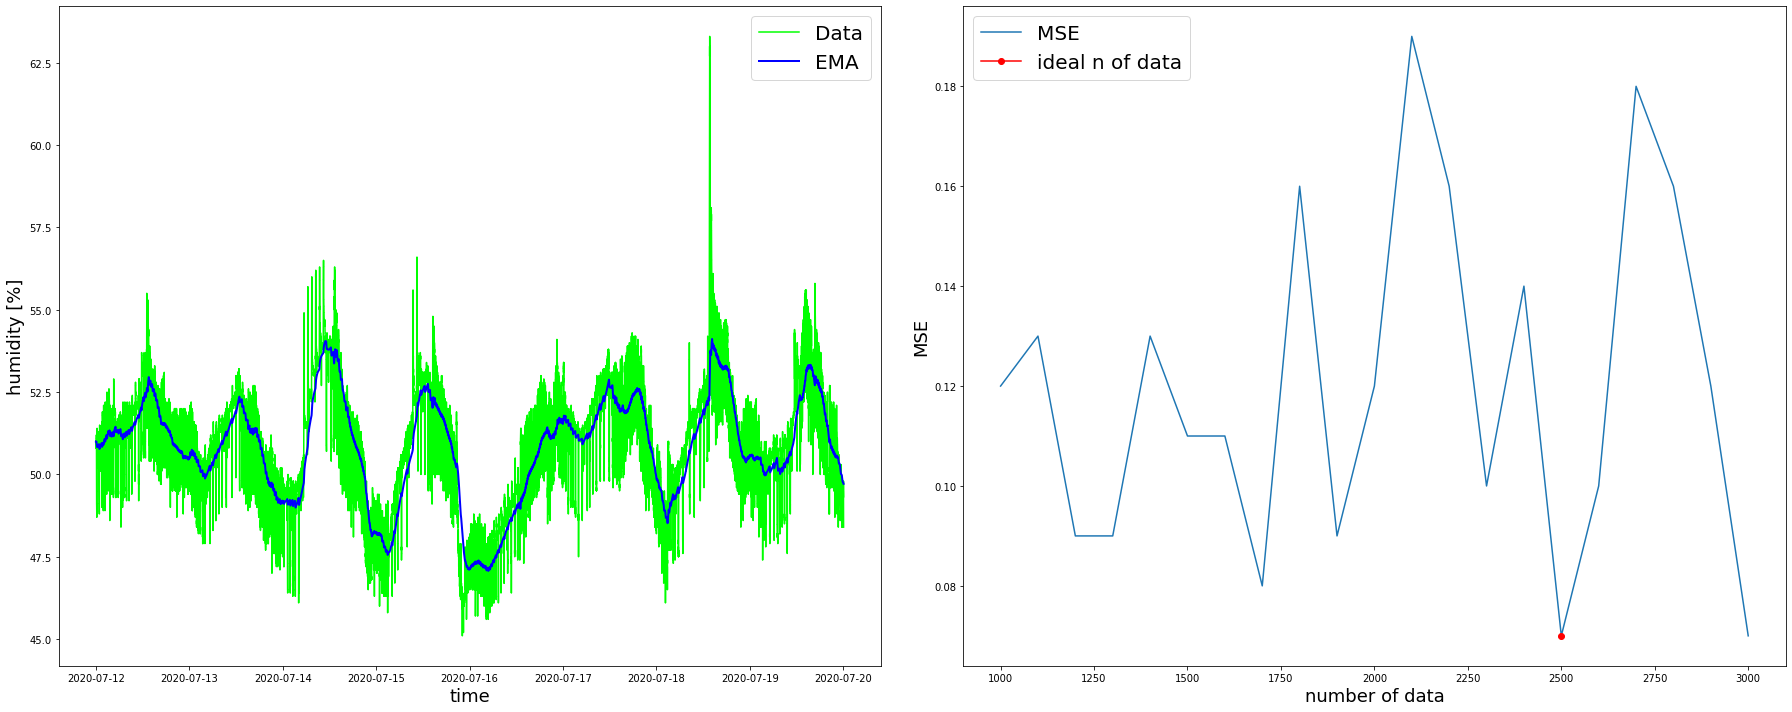

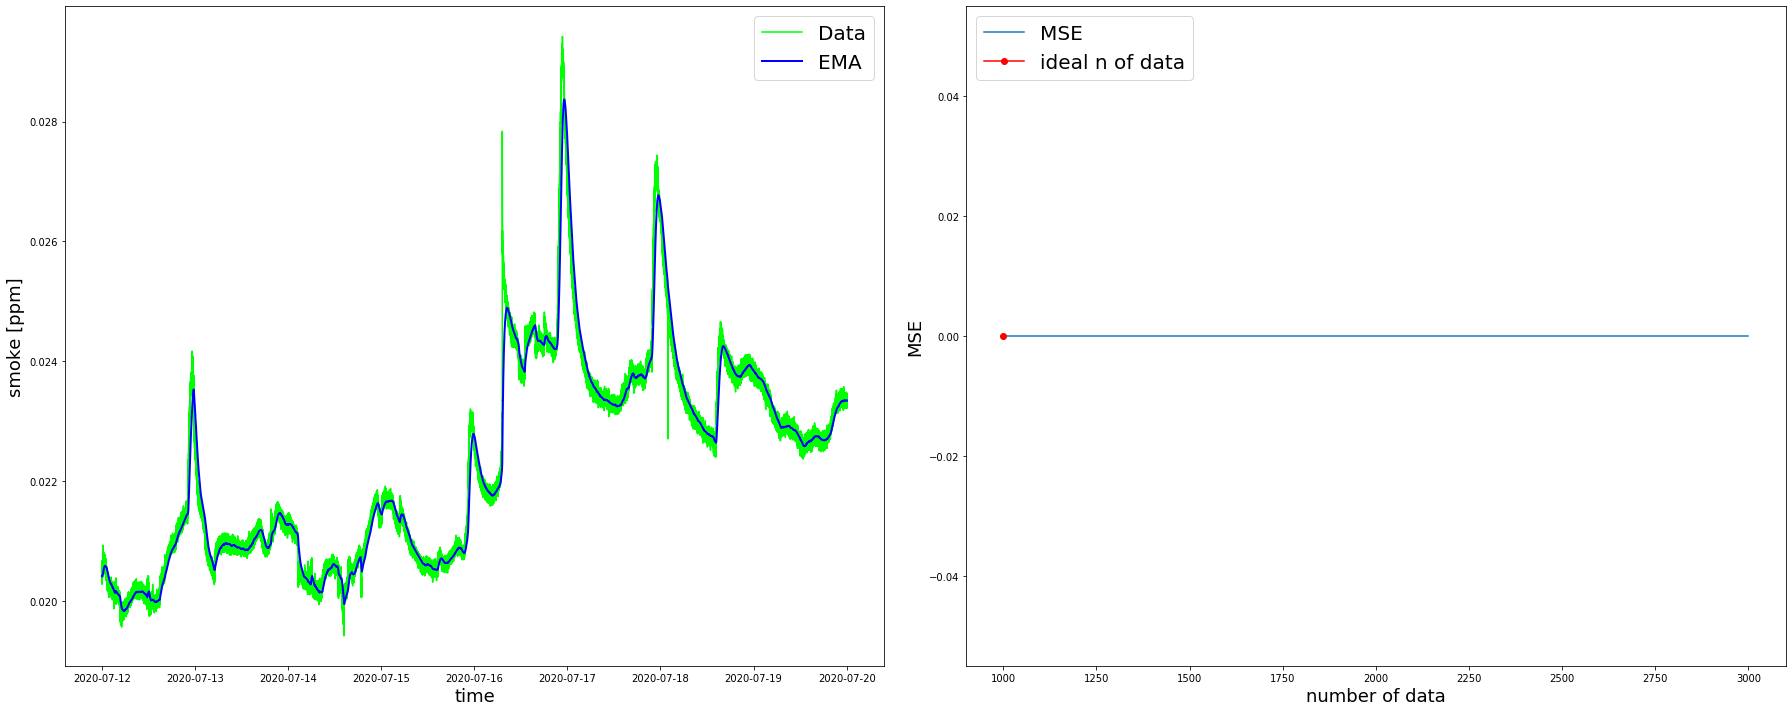

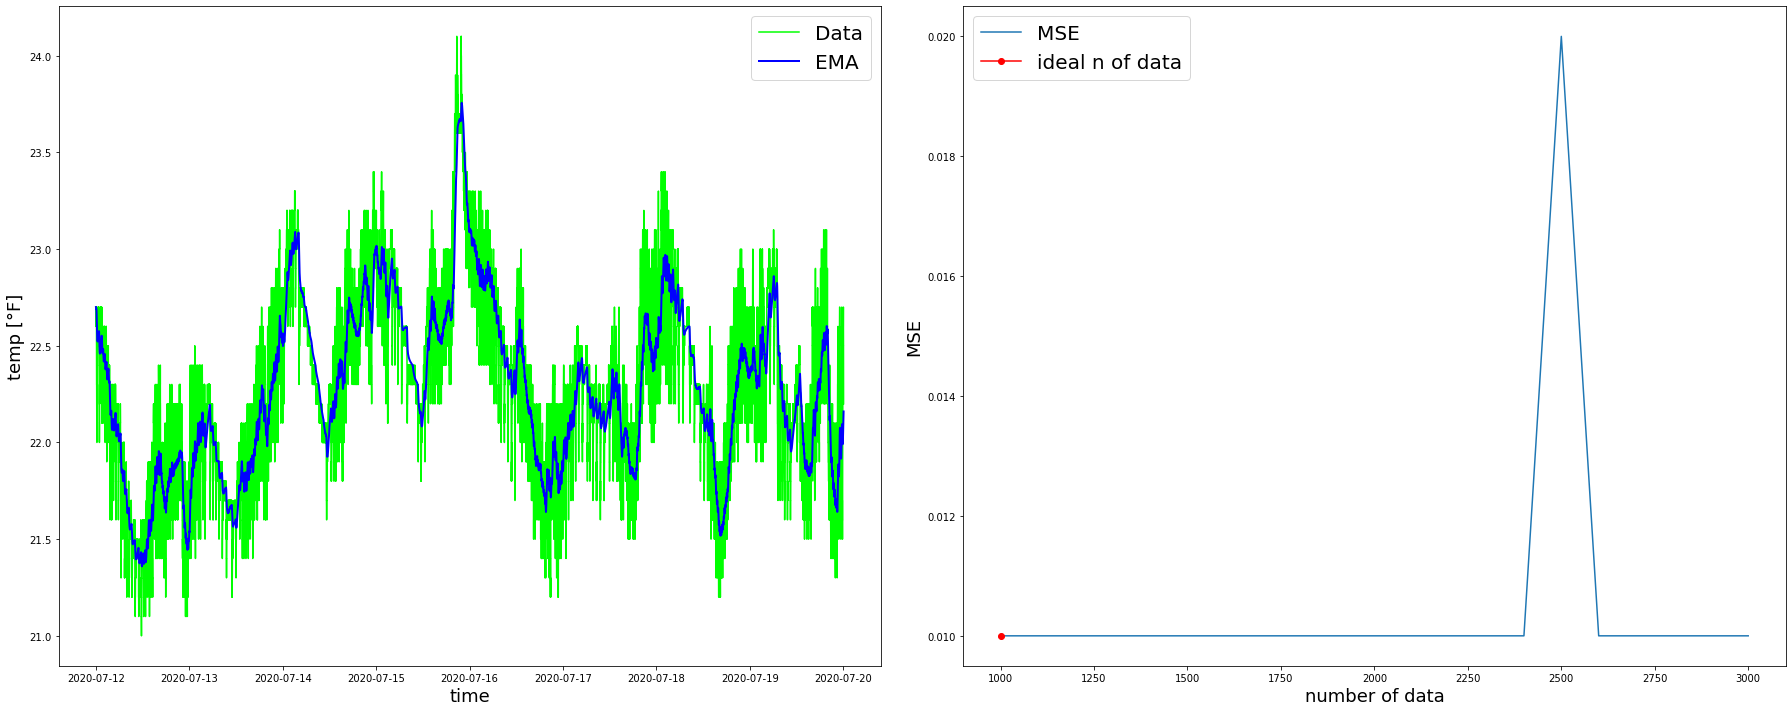

In [6]:
# dc_1_co = data_clean(dev_1.time, dev_1.co, x_label='time', y_label='co [ppm]', graphs=True)
dc_1_hum = data_clean(dev_1.time, dev_1.humidity, x_label='time', y_label='humidity [%]', graphs=True)
# dc_1_lpg = data_clean(dev_1.time, dev_1.lpg, x_label='time', y_label='LPG [ppm]', graphs=True)
dc_1_smoke = data_clean(dev_1.time, dev_1.smoke, x_label='time', y_label='smoke [ppm]', graphs=True)
dc_1_temp = data_clean(dev_1.time, dev_1.temp, x_label='time', y_label='temp [°F]', graphs=True)

In [7]:
df = pd.DataFrame({'time': dev_1.time,
                   # 'co': dc_1_co,
                   'humidity': dc_1_hum,
                   # 'lpg': dc_1_lpg,
                   'smoke': dc_1_smoke,
                   'temp': dc_1_temp,
                   'light': dev_1.light,
                   'motion': dev_1.motion})

df['pres'] = np.zeros(len(df), dtype=int)
df = df.sample(frac=.05, random_state=154)
df = df.sort_values(by='time', ascending=True)
df.index = range(0, len(df))

I consider an increase in parameters and the activation of the light and motion sensor as the fact that there is at least one person near the device.

In [8]:
name_col = df.columns[1:]

for i in name_col[:-1]:
    if df[i].dtype == 'float':
        for j in df.index:
            if j == 0 or df.pres[j] == 1:
                pass
            elif df[i][j - 1] < df[i][j] and df[i][j] - df[i][j - 1] > .0008:
                # .0008 is a random number but it must be replaced with other values such as, for example, the error of each sensor (error device[i]), in order not to consider an increase in the value below a certain threshold.
                df.loc[j, 'pres'] = 1
    else:
        for j in df.index:
            if df.pres[j] == 1:
                pass
            elif df[i][j] == 1:
                df.loc[j, 'pres'] = 1

## Random Forest

In [9]:
X, y = df[name_col[:-1]], df[name_col[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

I look for the optimal number of estimators that allows me to lower the OOB errors as much as possible.



In [10]:
oob_error = []
rn_est = list(range(30, 205, 5))
for i in rn_est:
    clf = RandomForestClassifier(max_features='sqrt', oob_score=True, n_estimators=i,
                                 random_state=123)
    clf.fit(X_train, y_train)
    oob_err = 1 - clf.oob_score_
    oob_error.append(oob_err)

best_n_est = rn_est[oob_error.index(min(oob_error))]


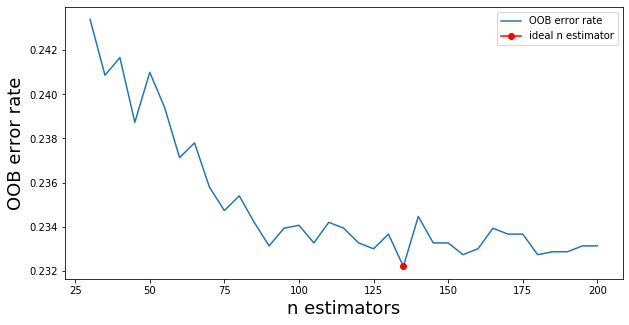

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(rn_est, oob_error, label='OOB error rate')
plt.plot(best_n_est, min(oob_error), marker='o', color='red', label='ideal n estimator')
plt.xlabel('n estimators', fontsize=18)
plt.ylabel('OOB error rate', fontsize=18)
plt.legend(loc='upper right', prop={'size': 10})
plt.show()


In [12]:
RF_classifier = RandomForestClassifier(max_features='sqrt', oob_score=True,
                                       n_estimators=best_n_est, random_state=123)

Accuracy= 0.7626666666666667


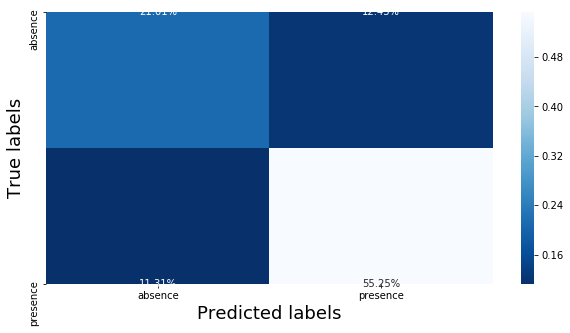

In [13]:
RF_classifier.fit(X_train, y_train)
y_RF_pred = RF_classifier.predict(X_test)
conf_mat(y_test, y_RF_pred)

### Feature Importance

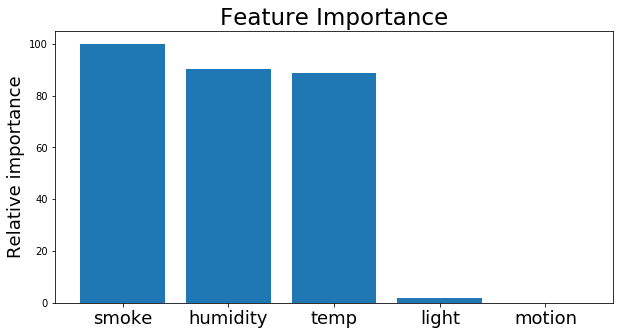

In [14]:
feature_importance = RF_classifier.feature_importances_
feature_names = name_col[:-1]
feature_importance = 100 * (feature_importance / max(feature_importance))

index_sorted = np.flipud(np.argsort(feature_importance))
pos = np.arange(index_sorted.shape[0]) + 0.5

plt.figure(figsize=(10, 5))
plt.bar(pos, feature_importance[index_sorted], align='center')
plt.xticks(pos, feature_names[index_sorted], fontsize=18)
plt.ylabel('Relative importance', fontsize=18)
plt.title('Feature Importance', fontsize=23)
plt.show()

## Application of the classifier on the second dataset

In [15]:
# dc_2_co = data_clean(dev_2.time, dev_2.co, x_label='time', y_label='co [ppm]', graphs=False)
dc_2_hum = data_clean(dev_2.time, dev_2.humidity, x_label='time', y_label='humidity [%]', graphs=False)
# dc_2_lpg = data_clean(dev_2.time, dev_2.lpg, x_label='time', y_label='LPG [ppm]', graphs=False)
dc_2_smoke = data_clean(dev_2.time, dev_2.smoke, x_label='time', y_label='smoke [ppm]', graphs=False)
dc_2_temp = data_clean(dev_2.time, dev_2.temp, x_label='time', y_label='temp [°F]', graphs=False)

df_2 = pd.DataFrame({'time': dev_2.time,
                     # 'co': dc_2_co,
                     'humidity': dc_2_hum,
                     # 'lpg': dc_2_lpg,
                     'smoke': dc_2_smoke,
                     'temp': dc_2_temp,
                     'light': dev_2.light,
                     'motion': dev_2.motion})

df_2['pres'] = np.zeros(len(df_2), dtype=int)
df_2 = df_2.sample(frac=0.5, random_state=154)
df_2 = df_2.sort_values(by='time', ascending=True)
df_2.index = range(0, len(df_2))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
y_RF_pred_2 = RF_classifier.predict(df_2[name_col[:-1]])

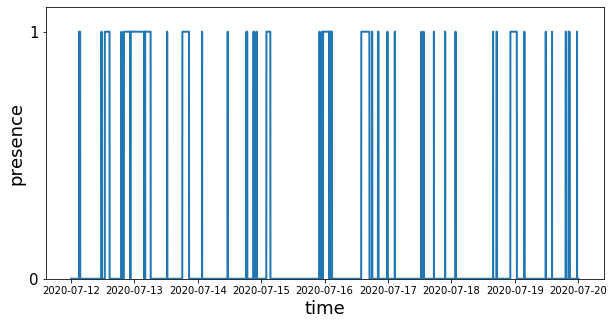

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df_2.time, y_RF_pred_2, linewidth=2)
plt.xlabel('time', fontsize=18)
plt.ylabel('presence', fontsize=18)
plt.yticks([0, 1], fontsize=15)
plt.ylim(0, 1.1)
plt.show()

## Application of the classifier on the third dataset

In [18]:
# dc_3_co = data_clean(dev_3.time, dev_3.co, x_label='time', y_label='co [ppm]', graphs=False)
dc_3_hum = data_clean(dev_3.time, dev_3.humidity, x_label='time', y_label='humidity [%]', graphs=False)
# dc_3_lpg = data_clean(dev_3.time, dev_3.lpg, x_label='time', y_label='LPG [ppm]', graphs=False)
dc_3_smoke = data_clean(dev_3.time, dev_3.smoke, x_label='time', y_label='smoke [ppm]', graphs=False)
dc_3_temp = data_clean(dev_3.time, dev_3.temp, x_label='time', y_label='temp [°F]', graphs=False)

df_3 = pd.DataFrame({'time': dev_3.time,
                     # 'co': dc_3_co,
                     'humidity': dc_3_hum,
                     # 'lpg': dc_3_lpg,
                     'smoke': dc_3_smoke,
                     'temp': dc_3_temp,
                     'light': dev_3.light,
                     'motion': dev_3.motion})

df_3['pres'] = np.zeros(len(df_3), dtype=int)
df_3 = df_3.sample(frac=0.5, random_state=154)
df_3 = df_3.sort_values(by='time', ascending=True)
df_3.index = range(0, len(df_3))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
y_RF_pred_3 = RF_classifier.predict(df_3[name_col[:-1]])

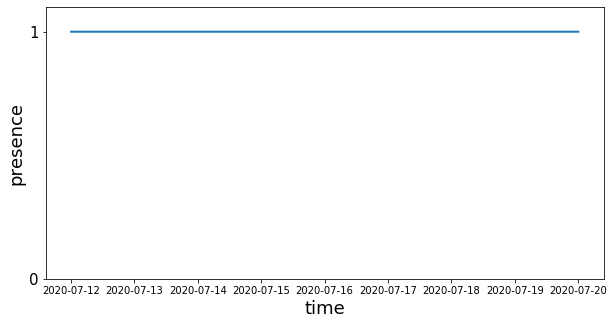

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(df_3.time, y_RF_pred_3, linewidth=2)
plt.xlabel('time', fontsize=18)
plt.ylabel('presence', fontsize=18)
plt.yticks([0, 1], fontsize=15)
plt.ylim(0, 1.1)
plt.show()

Another way to implement this program would be to consider the number of increasing parameters such as, if they are more than a certain percentage of the number of parameters, the device considers that fact to be someone's presence. Each parameter must be assigned a probability such as, if the light or motion sensor is activated, I'm sure there is someone near the device, so I can assign them a P = 1. For the CO sensor a different one can be assigned because increasing that parameter may mean that the heating system is faulty. This approach can be applied for the other sensors:

- smoke and temperature sensors: it can mean that something is taking fire;
- LPG sensor: if the device is mounted on an LPG car, it may mean that the LPG cylinder is leaking gas.